In [5]:
# Required only when running on Windows
# Add the latest files to the path
%matplotlib inline
import sys
import pandas as pd
#import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt

#sys.path.insert(0, r'\\newwinsrc\sasgen\dev\mva-vb005\GTKWX6ND\misc\python')

## Connect to CAS

In [9]:
from swat import *
cassession = CAS('sasserver.demo.sas.com', 5570, authinfo='~/.authinfo', caslib="casuser")
cassession.loadactionset(actionset="table")

NOTE: Added action set 'table'.


[actionset]

 'table'

+ Elapsed: 0.00252s, user: 0.001s, mem: 0.0553mb

## Check the server status


In [23]:
cassession.builtins.serverstatus()

NOTE: Grid node action status report: 1 nodes, 69 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Copyright': 'Copyright © 2014-2016 SAS Institute Inc. All Rights Reserved.',
  'System': {'Hostname': 'racesx08021',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '2.6.32-642.4.2.el6.x86_64',
   'OS Version': '#1 SMP Tue Aug 23 19:58:13 UTC 2016'},
  'Version': '3.01',
  'VersionLong': 'V.03.01M0P09072016',
  'license': {'expires': '20Sep2017:00:00:00',
   'gracePeriod': 45,
   'maxCPUs': 9999,
   'site': 'GA - Full Order 16w38 20Sep2016',
   'siteNum': 70068118,
   'warningPeriod': 65}}

[server]

 Server Status
 
    nodes  actions
 0      1       69

[nodestatus]

 Node Status
 
                        name        role    uptime  running  stalled
 0  racesx08021.demo.sas.com  controller  2249.717        0        0

+ Elapsed: 0.132s, sys: 0.002s, mem: 0.063mb

----
## Load data set

In [10]:
# Show available caslibs
cassession.caslibinfo()

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal
0,CASUSER(viyauser),PATH,Personal File System Caslib,/home/viyauser/casuser/,,1.0,0.0,1.0,1.0
1,Formats,PATH,CAS Formats caslib,/opt/sas/viya/config/data/cas/default/formats/,,1.0,0.0,0.0,0.0
2,Public,PATH,CAS Public caslib,/opt/sas/viya/config/data/cas/default/public/,,1.0,0.0,0.0,0.0


In [11]:
# Upload a SAS data set from Amazon S3 to CAS
result = cassession.upload('https://s3.amazonaws.com/sassna-fs/jozwal/hmeq.sas7bdat')
result

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(viyauser).
NOTE: The table HMEQ has been created in caslib CASUSER(viyauser) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(viyauser)'

[tableName]

 'HMEQ'

[casTable]

 CASTable('HMEQ', caslib='CASUSER(viyauser)')

+ Elapsed: 0.0669s, user: 0.013s, sys: 0.012s, mem: 2.15mb

In [14]:
# Generate an ID column for the data set. Will allow us to uniquely identify rows
# NOTE: use of _N_ is not recommended, especially in MPP environments
# TODO: Replace with SQL when possible.

cassession.loadactionset('datastep')

cassession.datastep.runcode("""
    DATA hmeq;
        ID=_N_;
        SET hmeq;
    RUN;
""")

NOTE: Added action set 'datastep'.


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),hmeq,5960,13,"CASTable('hmeq', caslib='CASUSER(viyauser)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),hmeq,5960,14,"CASTable('hmeq', caslib='CASUSER(viyauser)')"


In [13]:
# Save pointer to in-memory table in CAS
hmeq = result.casTable
hmeq.head()

# Bad = 1 if applicat defaulted on the loan
# Loan = Requested loan amount
# MortDue = Amount due on existing mortgage
# Value = Value of current property
# Reason = DebtCon / HomeImp
# Job = Occupation category
# YoJ = Years at current job
# Derog = # of major derogatory reports
# Delinq = Number of delinquent credit lines
# CLAge = Age of oldest credit line in months
# NInq = # of recent credit inquiries
# CLNo = # of credit lines
# DebtInc = Debt:Income ratio

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


----
## Load action sets

In [19]:
%%capture 

# Instruct CAS to load action sets if not already loaded.
#cas.loadactionset('cardinality')
#cas.loadactionset('dataPreprocess')
#cas.loadactionset('varReduce')
#cas.loadactionset('clustering')
#cas.loadactionset('pca')
#cas.loadactionset('sampling')
#cas.loadactionset('decisionTree')
#cas.loadactionset('dataStep')
#cas.loadactionset('neuralNet')
#cas.loadactionset('svm')
#cas.loadactionset('astore')
#cas.loadactionset('fedsql')
#cas.loadactionset('percentile')

#  create python list containing the required CAS Actionsets
casActionsets = ['cardinality','dataPreprocess','varReduce','clustering','pca','sampling','decisionTree','dataStep','neuralNet','svm','astore','fedsql','percentile']

# use list comprehension to loade these actionsets
[cassession.loadactionset(actionset=i) for i in casActionsets]

# list loaded actionsets
cassession.actionsetinfo(all=False)

,actionset,label,loaded,extension,build_time,portdate
0,accessControl,Access Controls,1,tkacon,2016-09-07 18:41:50,V.03.01M0P09072016
1,accessControl,Access Controls,1,casmeta,2016-09-07 18:41:50,V.03.01M0P09072016
2,astore,Analytic Store Scoring,1,astore,2016-09-07 17:51:14,V.03.01M0P09072016
3,builtins,System,1,tkcasablt,2016-09-07 18:41:50,V.03.01M0P09072016
4,cardinality,Cardinality Analysis,1,cardinality,2016-09-16 08:50:17,V.03.01M0P09072016
5,clustering,Clustering,1,tkcaskclus,2016-09-07 17:51:17,V.03.01M0P09072016
6,configuration,Server Properties,1,tkcascfg,2016-09-07 18:41:47,V.03.01M0P09072016
7,dataPreprocess,Data Preprocess,1,tktrans,2016-09-07 18:41:49,V.03.01M0P09072016
8,dataStep,DATA Step,1,datastep,2016-09-07 18:41:27,V.03.01M0P09072016
9,decisionTree,Decision Tree,1,tkcasdt,2016-09-07 18:41:49,V.03.01M0P09072016


----
## Explore Data

In [20]:
# Calculate summary statistics for each variable
hmeq.summarize(cardinality=dict(name='hmeq_card', replace=True))

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.000912774 seconds.


+ Elapsed: 0.921s, user: 0.093s, mem: 3.63mb

In [28]:
# Link to results and filter to just variables with missing values
hmeq_card = cassession.CASTable('hmeq_card', where='_NMISS_ > 0')

# Pull the results from the server.  Returned as child class of Pandas DF
df_hmeq_card = hmeq_card.fetch().Fetch
df_hmeq_card
# Note: What we just did is to calcualate summary statistics on the columns of the table in CAS, then return these
#       results back to local Python ina  pandas dataframe. We would NEVER do this with a large CAS table but this
#       is very handy when dealing with small results. So we can go back and forth with the computation locality.

,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,...,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
0,MORTDUE,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5442.0,518.0,...,1.814481,6.481866,5411.0,N,NaN,,,6124.000000,,6124
1,VALUE,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5848.0,112.0,...,3.053344,24.362805,5818.0,N,NaN,,,20631.000000,,20631
2,REASON,7.0,C,CLASS,ASC,N,2.0,5960.0,5708.0,252.0,...,NaN,NaN,3928.0,Y,NaN,DebtCon,DebtCon,NaN,HomeImp,HomeImp
3,JOB,7.0,C,CLASS,ASC,N,6.0,5960.0,5681.0,279.0,...,NaN,NaN,2388.0,Y,NaN,Other,Other,NaN,Self,Self
4,YOJ,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5445.0,515.0,...,0.988460,0.372072,3876.0,N,NaN,,,3.700000,,3.7
5,DEROG,12.0,N,CLASS,ASC,N,11.0,5960.0,5252.0,708.0,...,5.320870,36.872763,4527.0,Y,0.0,,0,10.000000,,10
6,DELINQ,12.0,N,CLASS,ASC,N,14.0,5960.0,5380.0,580.0,...,4.023150,23.565449,4179.0,Y,0.0,,0,15.000000,,15
7,CLAGE,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5652.0,308.0,...,1.343412,7.599549,5619.0,N,NaN,,,15.233333,,15.233333333
8,NINQ,12.0,N,CLASS,ASC,N,16.0,5960.0,5450.0,510.0,...,2.621984,9.786507,2531.0,Y,0.0,,0,17.000000,,17
9,CLNO,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5738.0,222.0,...,0.775052,1.157673,1049.0,N,NaN,,,29.000000,,29


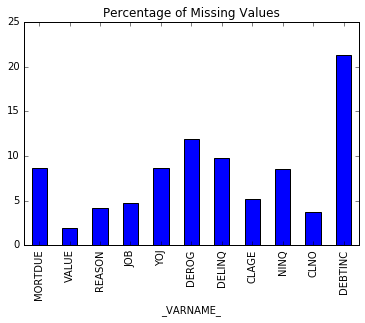

In [36]:
# Calculate percentage of each variable that's missing
# Performed locally using Pandas
df_hmeq_card['Percent_Missing']  = df_hmeq_card._NMISS_ / df_hmeq_card._NOBS_ * 100

# Plot results
# Performed locally using Pandas Bar Plotting
df_hmeq_card.plot.bar('_VARNAME_','Percent_Missing', title='Percentage of Missing Values', legend=False)

----
## Impute missing values

In [45]:
# Note: We are now using a pointer to a cas table, so we will be executing in CAS, not locally. The following command
# is a python function that returns the "type" of the object - when demoing you can switch out between the two statements 
# to show insight into computation locality (the print function forces each result to be shown, otherwise Jupyter will only 
# show the last function result)
print(type(hmeq))
print(type(df_hmeq_card)


<class 'swat.cas.table.CASTable'>
<class 'swat.dataframe.SASDataFrame'>


In [46]:
# Preview data.  Credit Line Age (CLAge) has missing values. The head function is a CAS function that mimics the python head
hmeq.head()

,ID,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,2.0,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,3.0,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,4.0,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [47]:
# Impute missing values for a single column (clage)
result = hmeq.datapreprocess.impute(casout=dict(name='hmeq_prepped', replace=True),
                                   allIdVars=True,
                                   techForCont='MEAN',
                                   vars='clage')

hmeq_prepped = result.OutputCasTables.ix[0,'casTable']
result.ImputeInfo

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous
0,CLAGE,Mean,IMP_CLAGE,5652.0,308.0,179.766275


In [48]:
# Select min and max values for NInq column using SQL
ninq_range = cassession.fedsql.execdirect("SELECT _min_, _max_ FROM hmeq_card WHERE _varname_='NINQ'")['Result Set']
ninq_min = ninq_range['_MIN_'][0]
ninq_max = ninq_range['_MAX_'][0]

# Pipeline multiple imputation steps.
result = hmeq.datapreprocess.transform(casOut=dict(name='hmeq_prepped', replace=True),
                             allIdVars=True,
                             outVarsNameGlobalPrefix='IM',
                             reqPacks=[
                                dict(impute='mean', inputs='clage'),
                                dict(impute='median', inputs='delinq'),
                                dict(impute={'method':'random', 'minrandom':ninq_min, 'maxrandom':ninq_max}, 
                                     inputs='ninq'),
                                dict(impute={'method':'value', 'valuesContinuous':[50,100]}, 
                                     inputs=['debtinc','yoj'])
                             ])

hmeq_prepped = result.OutputCasTables.ix[0,'casTable']
result.VarTransInfo

,Variable,Transformation,ResultVar,N,NMiss,ImputedValueContinuous
0,CLAGE,IM,IM_CLAGE,5652,308,179.766275
1,DEBTINC,IM,IM_DEBTINC,4693,1267,50.000000
2,DELINQ,IM,IM_DELINQ,5380,580,0.000000
3,NINQ,IM,IM_NINQ,5450,510,NaN
4,YOJ,IM,IM_YOJ,5445,515,100.000000


In [57]:
print(type(hmeq_prepped))
hmeq_prepped.head()

<class 'swat.cas.table.CASTable'>


,ID,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,IM_CLAGE,IM_DEBTINC,IM_DELINQ,IM_NINQ,IM_YOJ
0,1.0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,94.366667,50.0,0.0,1.000000,10.5
1,2.0,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,121.833333,50.0,2.0,0.000000,7.0
2,3.0,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,149.466667,50.0,0.0,1.000000,4.0
3,4.0,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.766275,50.0,0.0,16.452379,100.0
4,5.0,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,93.333333,50.0,0.0,0.000000,3.0


----
## Dimensionality reduction

In [58]:
model = dict(depvars='bad', 
             effects=[{'vars':['loan','mortdue','value','reason','job','yoj','derog','delinq',
                               'clage','ninq','clno','debtinc','im_clage','im_debtinc','im_delinq',
                               'im_ninq','im_yoj']}])

# Perform supervised variable selection using discriminant analysis. Return max of 8 features.
hmeq_prepped.varreduce.super(analysis='DSC', class_=[dict(vars=['bad','reason','job'])],
                            model=model,
                            maxeffects=8,
                            outputtables=dict(names=['SelectionSummary','SelectedEffects']))

NOTE: The CAS table 'SelectionSummary' in caslib 'CASUSER(viyauser)' has 9 rows and 9 columns.
NOTE: The CAS table 'SelectedEffects' in caslib 'CASUSER(viyauser)' has 8 rows and 3 columns.


[Nobs]

 Number of Observations
 
    RowId                         Type       N
 0  NREAD  Number of Observations Read  5960.0
 1  NUSED  Number of Observations Used  3364.0

[SelectionSummary]

 Selection Summary
 
    Iteration Variable   Parameter    VarExp       SSE       MSE       AIC  \
 0          1   DELINQ      DELINQ  0.075566  0.924434  0.000275 -0.075601   
 1          2    DEROG       DEROG  0.121981  0.878019  0.000261 -0.125926   
 2          3  DEBTINC     DEBTINC  0.162079  0.837921  0.000249 -0.171481   
 3          4    CLAGE       CLAGE  0.171179  0.828821  0.000247 -0.181212   
 4          5      JOB   JOB Sales  0.175310  0.824690  0.000246 -0.185018   
 5          6     NINQ        NINQ  0.178094  0.821906  0.000245 -0.187211   
 6          7     CLNO        CLNO  0.180792  0.819208  0.000244 -0.189310   
 7          8      JOB  JOB Office  0.182195  0.817805  0.000244 -0.189835   
 8          9     LOAN        LOAN  0.183303  0.816697  0.000243 -0.190002   
 
        AICC       BIC  
 0  1.924402 -0.076160  
 1  1.874080 -0.125259  
 2  1.828529 -0.169589  
 3  1.818802 -0.178095  
 4  1.815000 -0.180677  
 5  1.812813 -0.181644  
 6  1.810720 -0.182518  
 7  1.810202 -0.181819  
 8  1.810043 -0.180761  

[SelectedEffects]

 Selected Variables
 
    Number Variable      Type
 0       1   DELINQ  INTERVAL
 1       2    DEROG  INTERVAL
 2       3  DEBTINC  INTERVAL
 3       4    CLAGE  INTERVAL
 4       5      JOB     CLASS
 5       6     NINQ  INTERVAL
 6       7     CLNO  INTERVAL
 7       8     LOAN  INTERVAL

+ Elapsed: 0.0299s, user: 0.048s, sys: 0.004s, mem: 1.27mb

In [59]:
# Retrieve the selection metrics from CAS
summ = cassession.CASTable('SelectionSummary').fetch().Fetch

# Rescale the values using Sklearn so they can be plotted together
cols = ['VarExp', 'MSE','AIC','BIC','SSE','AICC']
summ[cols] = preprocessing.MinMaxScaler().fit_transform(summ[cols].values)

# Reshape using Pandas
summ = pd.melt(summ, id_vars=['Iteration','Variable','Parameter'])

# Plot using Seaborn
# sns.pointplot(x='Iteration', y='value', hue='variable', data=summ, scale=0.75)

----
## K-Means clustering

In [60]:
# Use K-means to compute cluster assignments
hmeq_prepped.clustering.kclus(inputs=['loan','im_debtinc','im_clage',],
                              distance='EUCLIDEAN',
                              standardize='STD',
                              nclusters=6,
                              maxIters=50,
                              output=dict(casout=dict(name='hmeq_clusters', replace=True), copyvars='ALL'),
                              display=dict(names=['ModelInfo','ClusterSum','ClusterCenters']))

NOTE:  Using SEED=2090803622.
NOTE: Running for input data for K 6.
NOTE: Clustering is finished. STOPVALUE is satisfied for STOPCRITERION=CLUSTER_CHANGE.


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 22}

[ModelInfo]

 Model Information
 
               Parameter         Setting
 0    Maximum Iterations              50
 1        Stop Criterion  Cluster Change
 2  Stop Criterion Value               0
 3              Clusters               6
 4        Initialization           Forgy
 5                  Seed      2090803622
 6              Distance       Euclidean
 7       Standardization             Std
 8   Interval Imputation            None

[ClusterSum]

 Cluster Summary for Interval Variables
 
    Cluster  Frequency   MinDist    MaxDist   AvgDist          SSE  \
 0        1     1414.0  0.154480   3.591028  0.909176  1422.106004   
 1        2      882.0  0.060891  15.420162  0.901631  1237.570948   
 2        3     1190.0  0.111735   2.753841  0.821653   881.239964   
 3        4     1137.0  0.057949   2.537329  0.815227   879.785415   
 4        5      999.0  0.109475  10.375881  1.036586  1603.816279   
 5        6      338.0  0.162778  10.611875  1.529118  1056.444510   
 
    StdDeviation  NearestClus  DBtwCentroids  
 0      1.002862          4.0       1.411855  
 1      1.184543          3.0       1.424686  
 2      0.860545          2.0       1.424686  
 3      0.879646          1.0       1.411855  
 4      1.267052          2.0       1.775413  
 5      1.767930          4.0       2.348883  

[ClusterCenters]

 Cluster Centroids
 
    _ITERATION_  _CLUSTER_ID_          LOAN  IM_DEBTINC    IM_CLAGE    S_LOAN  \
 0         44.0           1.0  13804.596888   27.076838  151.693749 -0.428586   
 1         44.0           2.0  14907.823129   47.966061  216.859776 -0.330150   
 2         44.0           3.0  11946.890756   44.446986  103.543740 -0.594342   
 3         44.0           4.0  25381.530343   36.811675  151.748492  0.604379   
 4         44.0           5.0  17980.580581   33.607739  302.964530 -0.055980   
 5         44.0           6.0  50878.402367   38.359494  198.890726  2.879366   
 
    S_IM_DEBTINC  S_IM_CLAGE  
 0     -1.003620   -0.335944  
 1      1.061636    0.443898  
 2      0.713715   -0.912156  
 3     -0.041165   -0.335289  
 4     -0.357929    1.474315  
 5      0.111863    0.228863  

+ Elapsed: 0.127s, user: 0.295s, sys: 0.001s, mem: 6.19mb

In [62]:
cassession.CASTable('hmeq_clusters').head()

,ID,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,...,CLNO,DEBTINC,IM_CLAGE,IM_DEBTINC,IM_DELINQ,IM_NINQ,IM_YOJ,_CLUSTER_ID_,_DISTANCE_,_STANDARDIZED_DISTANCE_
0,1.0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,...,9.0,NaN,94.366667,50.0,0.0,1.000000,10.5,3.0,10846.896060,1.118106
1,2.0,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,...,14.0,NaN,121.833333,50.0,2.0,0.000000,7.0,3.0,10646.907914,1.118830
2,3.0,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,...,10.0,NaN,149.466667,50.0,0.0,1.000000,4.0,3.0,10446.993167,1.213386
3,4.0,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,...,NaN,NaN,179.766275,50.0,0.0,16.452379,100.0,2.0,13407.874594,1.291775
4,5.0,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,...,14.0,NaN,93.333333,50.0,0.0,0.000000,3.0,3.0,10246.897348,1.073438


----
## Partition data

In [64]:
# Build list of retained features using results from varreduce
columns = ['BAD'] 
columns.extend(list(cassession.CASTable('SelectedEffects').fetch().Fetch['Variable']))
columns = ', '.join(['prep.{}'.format(x) for x in columns])

# Join tables and select feature set
# Using in-line FedSQL options to control CAS behavior
query = """CREATE TABLE hmeq_reduced {{options replace=true, replication=0}} AS (
                SELECT {},
                      clust._cluster_id_ as cluster
               FROM hmeq_prepped as prep
               LEFT OUTER JOIN hmeq_clusters as clust ON prep.id=clust.id
           )
""".format(columns)

cassession.fedsql.execdirect(query)

NOTE: Table HMEQ_REDUCED was created in caslib CASUSER(viyauser) with 5960 rows returned.


+ Elapsed: 0.0557s, user: 0.063s, sys: 0.027s, mem: 13.8mb

In [66]:
# Split the data into training and crossval sets.  70/30 split, adding an indicator column
hmeq_part = cassession.sampling.stratified(table='hmeq_reduced',
                                 sampPct=70,
                                 partInd=True,
                                 output=dict(casout=dict(name='hmeq_part', replace=True), 
                                 copyvars='ALL')).OutputCasTables.ix[0,'casTable']
hmeq_part.head()

NOTE: Using SEED=4615244 for sampling.


,BAD,DELINQ,DEROG,DEBTINC,CLAGE,JOB,NINQ,CLNO,LOAN,CLUSTER,_PartInd_
0,1.0,0.0,0.0,NaN,94.366667,Other,1.0,9.0,1100.0,3.0,1.0
1,1.0,2.0,0.0,NaN,121.833333,Other,0.0,14.0,1300.0,3.0,0.0
2,1.0,0.0,0.0,NaN,149.466667,Other,1.0,10.0,1500.0,3.0,1.0
3,1.0,NaN,NaN,NaN,NaN,,NaN,NaN,1500.0,2.0,1.0
4,0.0,0.0,0.0,NaN,93.333333,Office,0.0,14.0,1700.0,3.0,1.0


In [67]:
# Define some commonly used inputs
train = cassession.CASTable(name='hmeq_part', where='_PartInd_ = 1')
crossval = cassession.CASTable(name='hmeq_part', where='_PartInd_ = 0')
features = ['delinq','derog','clage','job','ninq','clno','loan','cluster']
nominal_fields = ['bad', 'job']

----
## Gradient Boosting

In [68]:
# Train a gradient boosting model
hmeq_part.decisiontree.gbtreetrain(table=train, inputs=features, nominals=nominal_fields,
                                   target='bad',
                                   nTree=10,
                                   nBins=20,
                                   varImp=True,
                                   missing='USEINSEARCH',
                                   casOut=dict(name='gb_model', replace=True)
                                  )

,Descr,Value
0,Number of Trees,10.0
1,Distribution,2.0
2,Learning Rate,0.1
3,Subsampling Rate,0.5
4,Number of Selected Variables (M),8.0
5,Number of Bins,20.0
6,Number of Variables,8.0
7,Max Number of Tree Nodes,59.0
8,Min Number of Tree Nodes,45.0
9,Max Number of Branches,2.0


In [69]:
# Score the model using the crossvalidation data
result = crossval.decisiontree.gbtreescore(model='gb_model',
                                            casout=dict(name='hmeq_scored_gb', replace=True),
                                            copyVars=['bad','_PartInd_'])

# Save a pointer to the output in CAS
hmeq_scored_gb = result.OutputCasTables.ix[0,'casTable']

# Display summary of results
result.ScoreInfo

,Descr,Value
0,Number of Observations Read,1788
1,Number of Observations Used,1788
2,Misclassification Error (%),15.771812081


In [70]:
hmeq_scored_gb.head()

,BAD,_PartInd_,_GBT_PredName_,_GBT_PredP_,_GBT_PredLevel_,_MissIt_
0,1.0,0.0,1,0.501445,0.0,0.0
1,1.0,0.0,1,0.601155,0.0,0.0
2,1.0,0.0,0,0.633472,1.0,1.0
3,1.0,0.0,0,0.728296,1.0,1.0
4,1.0,0.0,0,0.535406,1.0,1.0


---
## Neural Network

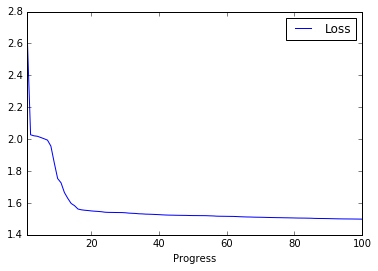

In [71]:
# Fit a neural network to the data
result = train.neuralNet.annTrain(validTable=crossval,
                       inputs=features,
                       nominals=nominal_fields,
                       target='bad',
                       hiddens=2,
                       acts='TANH',
                       combs='LINEAR',
                       targetAct='SOFTMAX',
                       errorFunc='ENTROPY',
                       std='MIDRANGE',
                       randDist='UNIFORM',
                       scaleInit=1,
                       nloOpts=dict(
                        optmlOpt = dict(maxIters=100, fConv=1e-10),
                        lbfgsOpt = dict(numCorrections=6),
                        printOpt = dict(printLevel='printDetail'),
                        validate = dict(frequency=1)
                       ),
                       casOut=dict(name='nn_model', replace=True)
                      )

# Plot the error by iteration
result.OptIterHistory[['Loss','Progress']].plot(x='Progress')

In [73]:
# Use the model to score the training & crossvalidation data
result = cassession.neuralNet.annScore(
    table=hmeq_part,
    modelTable='nn_model',
    casOut=dict(name='nn_scored', replace=True),
    copyVars=['BAD', '_PartInd_']
)

nn_scored = cassession.CASTable('nn_scored')
nn_scored.head()

,BAD,_PartInd_,_NN_PredName_,_NN_PredP_
0,1.0,1.0,0,0.543846
1,1.0,0.0,1,0.563246
2,1.0,1.0,0,0.675762
3,1.0,1.0,,NaN
4,0.0,1.0,0,0.695910


In [74]:
# _NN_PredP_ is the probability associated with the predicted value
# Convert this into separate columns for the probability that Bad=0 and Bad=1
cassession.dataStep.runCode("""
  DATA nn_scored;
      SET nn_scored;
      IF _nn_predname_=1 THEN do; 
          p_bad1=_nn_predp_; 
          p_bad0=1-p_bad1; 
      END; 
      IF _nn_predname_=0 THEN do; 
          p_bad0=_nn_predp_; 
          p_bad1=1-p_bad0; 
      END; 
  RUN;
""")

nn_scored.head()

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:48    0:153
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 4 times)
      0:48    0:153  (occurred 4 times)


,BAD,_PartInd_,_NN_PredName_,_NN_PredP_,p_bad1,p_bad0
0,1.0,1.0,0,0.543846,0.456154,0.543846
1,1.0,0.0,1,0.563246,0.563246,0.436754
2,1.0,1.0,0,0.675762,0.324238,0.675762
3,1.0,1.0,,NaN,NaN,NaN
4,0.0,1.0,0,0.695910,0.304090,0.695910


In [76]:
# Use the Assess action on the scored crossvalidation data to generate ROC and Lift statistics
results = nn_scored[nn_scored['_PartInd_'] == 0].percentile.assess(
          inputs='P_Bad1',
          response='Bad',
          event='1',
          pVar='P_Bad0',
          pEvent='0'
        )

# Extract the ROC stats
roc = results.ROCInfo

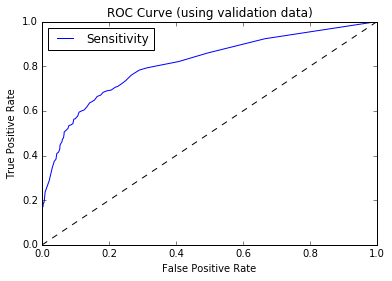

In [77]:
# Plot the ROC curve
plt.figure()

plt.plot(roc["FPR"], roc["Sensitivity"])
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

In [30]:
# Terminate the session
cas.close()